In [1]:
from bs4 import BeautifulSoup as bs
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import plotly.express as px
import descartes
import re
from datetime import datetime
import calmap

from sklearn.linear_model import LinearRegression, LogisticRegression
from VendorsParsingTools import *
from ForumParsingTools import *
from ProductListingParsingTools import *

# Table of content

## 1) General overview 
    1.0) Used datasets  
    1.1) Files obtained for each day  
    1.2) Services Uptime   
    1.3) Unusable files (celles qu'on a pas réussi à utiliser)  

## 2) Forum Analysis  
    2.1) Selected Features and DF  
    2.2.1) Data quality analysis
    2.2.2) Data Enrichment
    2.3) Index Stats Insight
    2.4) Topics Boards Insight

## 3) Market Analysis  
    3.1) Selected Features  
    3.2.1) Data Quality Analysis  
    3.2.2) Data Enrichment (typiquement en utilisant les données de grams)   
    3.3) Vendors Insight  
    3.4) Listings Insight  
   
## 4) Plan multi-variates analysis  
     ....
     


# 1) General overview

In [2]:
def cut_ag(s):
    return s[7:]

def cut_for(s):
    return s[14:]

agora_df = pd.read_csv('../data/agora_filesnum.out')
forum_df = pd.read_csv('../data/agora-forum_filesnum.out')

agora_df['day'] = agora_df['day'].apply(cut_ag)
forum_df['day'] = forum_df['day'].apply(cut_for)

agora_df['day'] = pd.to_datetime(agora_df['day'])
forum_df['day'] = pd.to_datetime(forum_df['day'])

agora_df = agora_df.set_index('day').sort_index()
forum_df = forum_df.set_index('day').sort_index()

all_days = pd.Series(pd.date_range(start='1/1/2014', end='31/12/2015', freq='D'))

all_days_df = pd.DataFrame({'day' : all_days})

all_days_df['filenum_ag'] = None
all_days_df['filenum_for'] = None

def replace_ag(r):
    if r in agora_df.index:
        return agora_df['filenum'].get(r)
def replace_for(r):
    if r in forum_df.index:
        return forum_df['filenum'].get(r)
    

all_days_df['filenum_ag'] = all_days_df['day'].apply(replace_ag)
all_days_df['filenum_for'] = all_days_df['day'].apply(replace_for)

all_days_df = all_days_df.set_index('day')

events_ag = pd.Series(all_days_df['filenum_ag'])
events_for = pd.Series(all_days_df['filenum_for'])

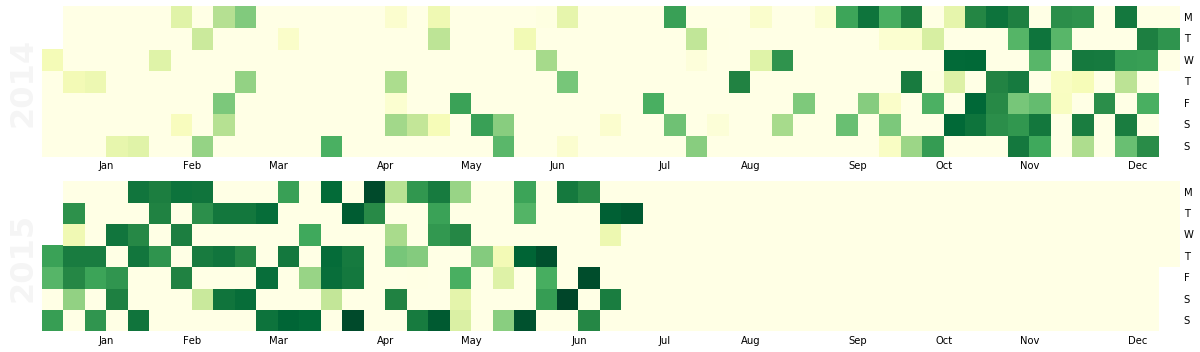

In [14]:
calmap.calendarplot(events_ag, daylabels='MTWTFSS', cmap='YlGn',
                    fillcolor='whitesmoke', linewidth=0, fig_kws=dict(figsize=(20, 5)));

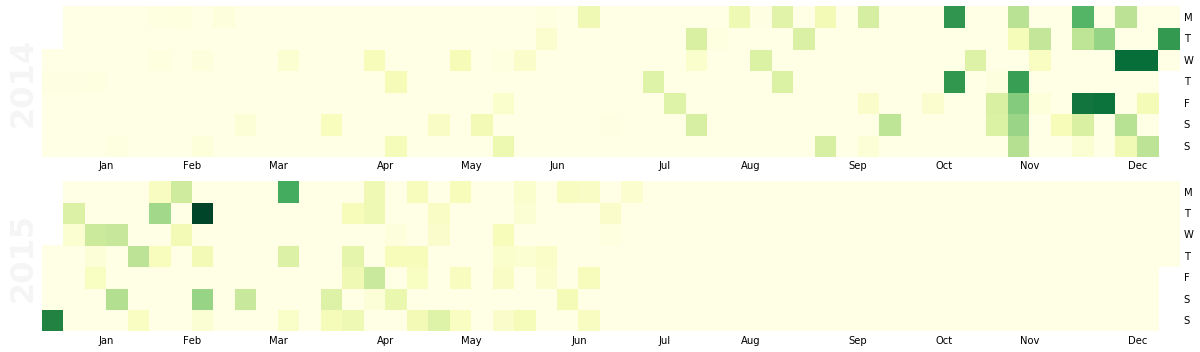

In [15]:
calmap.calendarplot(events_for,daylabels='MTWTFSS',cmap='YlGn',
                    fillcolor='whitesmoke',linewidth=0,fig_kws=dict(figsize=(20, 5)));

In [20]:
agora_df1 = pd.read_csv('../data/agora_stats.out', sep=",")
agora_df1 = agora_df1.drop(columns=['rid', 'speed_download', 'total_time'])
agora_df1['timestamp'] = agora_df1['timestamp'].apply(pd.to_datetime)

In [21]:
agora_df1

,sitename,siteup,timestamp,httpcode
0,Agora,1,2014-04-23 15:04:03,404
1,Agora,1,2014-04-23 15:15:05,404
2,Agora,1,2014-04-23 15:40:17,404
3,Agora,1,2014-04-23 15:45:03,404
4,Agora,1,2014-04-23 16:00:05,404
...,...,...,...,...
599388,Agora Forums,1,2017-03-25 22:34:01,503
599389,Agora Forums,1,2017-03-25 22:35:15,503
599390,Agora Forums,1,2017-03-25 22:40:20,503
599391,Agora Forums,1,2017-03-25 22:45:35,503


In [25]:
def fixIsUp(s):
    if(int(s) != 200):
        return 0
    else:
        return 1

def truncateTime(t):
    return t.round(freq='D')

In [26]:
agora_df1['siteup'] = agora_df1['httpcode'].apply(fixIsUp)

In [27]:
agora_df1['timestamp'] = agora_df1['timestamp'].apply(truncateTime)

In [28]:
agora_subdf1 = agora_df1[agora_df1['sitename'] == "Agora"]
forum_subdf1 = agora_df1[agora_df1['sitename'] == "Agora Forums"]

In [29]:
agora_subdf1 = agora_subdf1.groupby(by='timestamp').mean()
forum_subdf1 = forum_subdf1.groupby(by='timestamp').mean()

In [30]:
forum_subdf1.groupby(by='timestamp').describe()

siteup                                                        \
            count      mean std       min       25%       50%       75%   
timestamp                                                                 
2014-04-24    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
2014-04-25    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
2014-04-26    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
2014-04-27    1.0  0.989583 NaN  0.989583  0.989583  0.989583  0.989583   
2014-04-28    1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
...           ...       ...  ..       ...       ...       ...       ...   
2017-03-22    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-23    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-24    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-25    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   
2017-03-26    1.0  0.000000 NaN  0.000000  0.000000  0.000000  0.000000   

                     httpcode                                                  \
                 max    count       mean std        min        25%        50%   
timestamp                                                                       
2014-04-24  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
2014-04-25  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
2014-04-26  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
2014-04-27  0.989583      1.0  203.15625 NaN  203.15625  203.15625  203.15625   
2014-04-28  1.000000      1.0  200.00000 NaN  200.00000  200.00000  200.00000   
...              ...      ...        ...  ..        ...        ...        ...   
2017-03-22  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-23  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-24  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-25  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   
2017-03-26  0.000000      1.0  503.00000 NaN  503.00000  503.00000  503.00000   

                                  
                  75%        max  
timestamp                         
2014-04-24  200.00000  200.00000  
2014-04-25  200.00000  200.00000  
2014-04-26  200.00000  200.00000  
2014-04-27  203.15625  203.15625  
2014-04-28  200.00000  200.00000  
...               ...        ...  
2017-03-22  503.00000  503.00000  
2017-03-23  503.00000  503.00000  
2017-03-24  503.00000  503.00000  
2017-03-25  503.00000  503.00000  
2017-03-26  503.00000  503.00000  

[1053 rows x 16 columns]

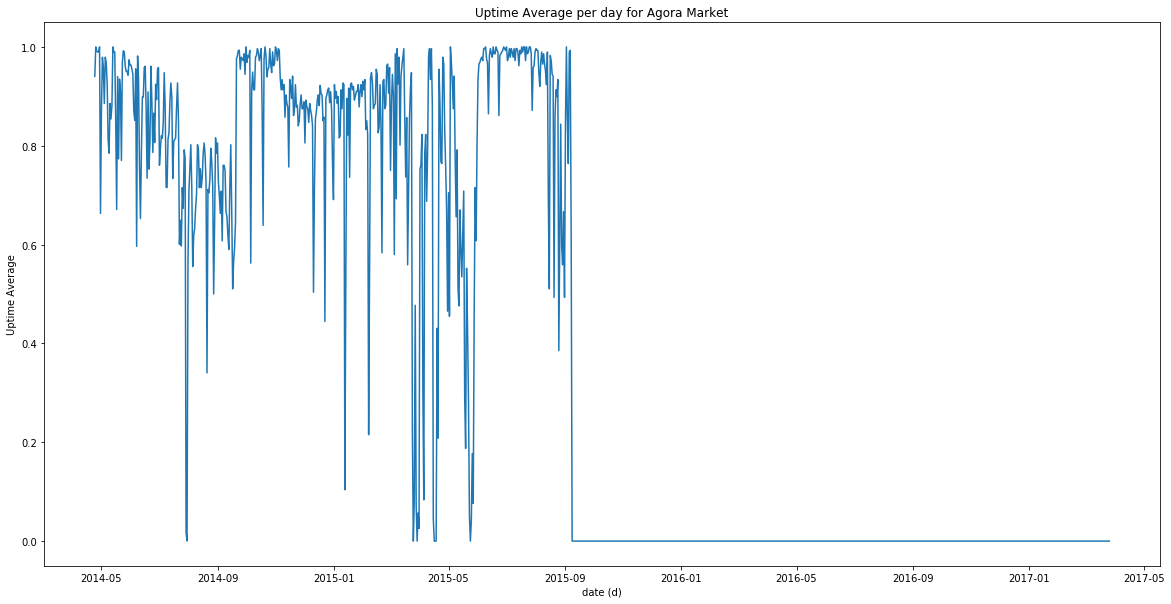

In [44]:
fig, ax1 = plt.subplots( figsize=(20,10))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(agora_subdf1.index, agora_subdf1['siteup'])
ax1.tick_params(axis='y')
plt.title('Uptime Average per day for Agora Market')
plt.show()

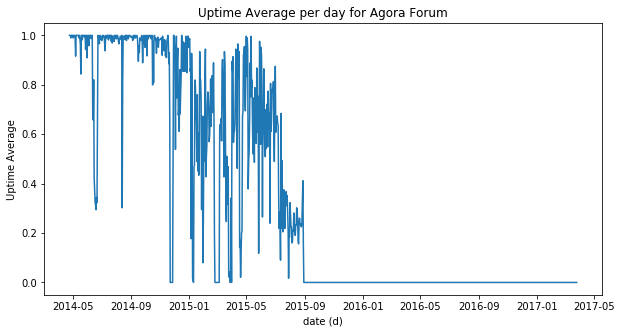

In [43]:
fig, ax1 = plt.subplots( figsize=(10,5))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(forum_subdf1.index, forum_subdf1['siteup'])
ax1.tick_params(axis='y')
plt.title('Uptime Average per day for Agora Forum')

plt.show()

In [33]:
date_range = pd.date_range(start='2014-11-01', end='2014-12-01', freq='D')

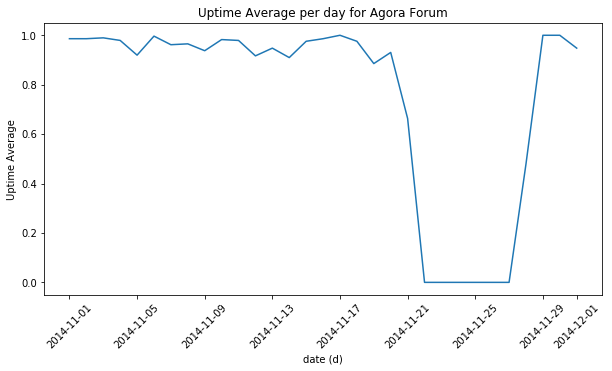

In [42]:
fig, ax1 = plt.subplots( figsize=(10,5))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(forum_subdf1.loc[date_range].index, forum_subdf1['siteup'][date_range])
ax1.tick_params(axis='y')
plt.xticks(rotation=45);
plt.title('Uptime Average per day for Agora Forum')

plt.show()

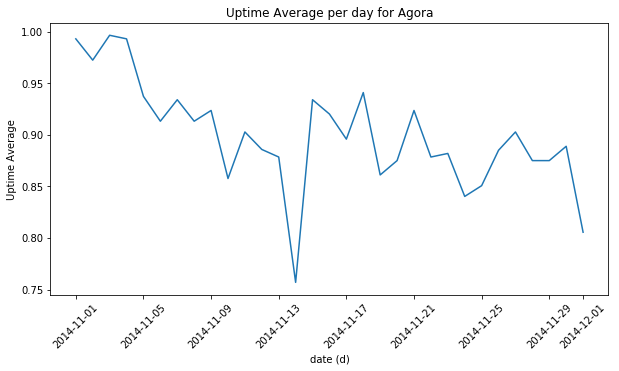

In [41]:
fig, ax1 = plt.subplots( figsize=(10,5))

ax1.set_xlabel('date (d)')
ax1.set_ylabel('Uptime Average')
ax1.plot(agora_subdf1.loc[date_range].index, agora_subdf1['siteup'][date_range])
ax1.tick_params(axis='y')
plt.xticks(rotation=45);
plt.title('Uptime Average per day for Agora')

plt.show()

# 2) Forum Analysis

In [16]:
with open('../data/agora_forum_days.out') as f:
    dates = f.readlines()

def cut(s):
    return s[:-1]
cut_v = np.vectorize(cut)

dates = cut_v(dates)

def fixDate(r):
    
    return str(r).replace("Today", '')

In [17]:
forumDF = pd.read_csv('../saved_gen_df/forumDF_full_df.csv')

# 3) Market Analysis

## 3.3) Vendors Insight

In [18]:
directory = "../data/agora/2014-04-06/vendor"
vendors = createVendorsDF(directory)

In [8]:
vendors.head(10)

,name,rating,lastSeen,publicKey,#products,#Deals
0,ozexpress,5.00,18 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,5,55~70
1,Band-Aid,5.00,8 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,2,25~40
2,DoctorMischief,5,1 hours,None,7,3~5
3,PillfirePharmacy,5.00,9 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,17,25~40
4,PureFireMeds,4.871,0 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,55,500~1000
5,PleasureNator,None,1 days 0 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----mQENBFMya2...,7,0
6,expressimportsAU,5.00,11 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: B...,2,40~55
7,Top_Gear_UK,4.99,5 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,16,70~100
8,XLVIoc,5,2 days 23 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,2,1~2
9,HAPPYholland,4.88,0 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,10,70~100


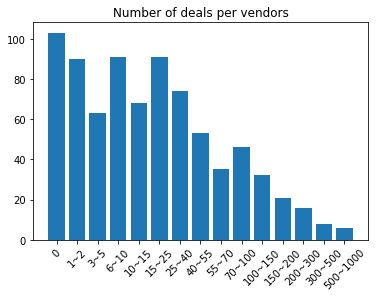

In [9]:
sortedStats = createStatsAboutNumbOfDeals(Counter(vendors['#Deals']))
plt.bar(sortedStats.keys(),sortedStats.values());
plt.xticks(rotation=45);
plt.title('Number of deals per vendors');

In [10]:
max(vendors['#products'])

386

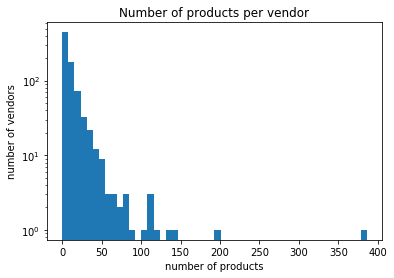

In [11]:
vendors['#products'].plot.hist(bins=50, logy=True)
plt.title('Number of products per vendor')
plt.xlabel('number of products')
plt.ylabel('number of vendors')
plt.show()

## 3.4) Listing insight

In [12]:
# example for synthetic pages
directory = "../data/agora/2014-04-06/cat/arXCLhtVhq/"
productsDF = directoryToDF(directory)
productsDF.head(10)

,name,price(BTC),from,to,vendor
0,1g JWH-018 - they don't make 'em like this any...,0.06397246,USA,None,nawlins
1,25g OMG I'M SO FUCKING STONED - 4% JWH-018 Smo...,0.17426983,USA,USA,nawlins
2,Axa Blends Blueberry Herbal Incense,0.15221035,USA,USA,axa
3,15g You should smoke this shit - like they do ...,0.17426983,USA,USA,nawlins
4,1000g OMG I'M SO FUCKING STONED - 4% JWH-018 S...,1.65446042,USA,USA,nawlins
5,5g You should smoke this shit - like they do i...,0.05294273,USA,USA,nawlins
6,5g OMG I'M SO FUCKING STONED - 4% JWH-018 Smok...,0.04301597,USA,None,nawlins
7,Axa Blends Pine Herbal Incense,0.15221035,USA,USA,axa
8,1 Gram 5F-UR-144,0.05514868,USA,Worldwide,SusnaSmith
9,1g JWH-073 - that MAGIC sparkle,0.05294273,USA,None,nawlins


In [13]:
country = productsDF['from'].unique()
country

array(['USA', 'Australia', 'HongKong', 'Sweden', 'Poland', 'UK'],
      dtype=object)